### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

### Unsloth

Let's prepare the OCR model to our local first

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

LICENSE: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

'/content/deepseek_ocr'

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = True, # Use 4bit to reduce memory use
    auto_model = AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.9: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at ./deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Project2_OCR/Dataset.zip'
extract_path = '/content/dataset_vietnamese'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Đã giải nén dữ liệu vào: {extract_path}")

Đã giải nén dữ liệu vào: /content/dataset_vietnamese


### Let's Evaluate Deepseek-OCR Baseline Performance on Persian Transcription

In [ ]:
import json

def load_vietnamese_test_set(base_path):
    test_samples = []
    if not os.path.exists(base_path):
        print(f"Lỗi: Không tìm thấy đường dẫn {base_path}")
        return []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        if os.path.isdir(subfolder_path):
            label_file = os.path.join(subfolder_path, 'label.json')
            if os.path.exists(label_file):
                with open(label_file, 'r', encoding='utf-8') as f:
                    labels = json.load(f)
                    for img_name, text in labels.items():
                        img_path = os.path.join(subfolder_path, img_name)
                        if os.path.exists(img_path):
                            test_samples.append({"image_path": img_path, "ground_truth": text})
    return test_samples

test_base_path = '/content/dataset_vietnamese/Dataset/test_data'
test_set = load_vietnamese_test_set(test_base_path)
print(f"Tổng số mẫu test tìm thấy: {len(test_set)}")

Tổng số mẫu test tìm thấy: 400


In [ ]:
import inspect

old_infer = model.infer

def patched_infer(*args, **kwargs):
    import io, contextlib
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        old_infer(*args, **kwargs)
    text = buf.getvalue()

    # lọc bỏ log rác, giữ text OCR
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    ocr_lines = [l for l in lines if not l.startswith(("BASE:", "PATCHES", "image:", "other:", "%", "="))]
    return " ".join(ocr_lines)

model.infer = patched_infer

In [ ]:
from jiwer import cer, wer
from tqdm import tqdm
import os
import unicodedata

def evaluate_baseline(model, tokenizer, test_samples):
    predictions = []
    ground_truths = []

    dummy_output = "/content/temp_results"
    if not os.path.exists(dummy_output):
        os.makedirs(dummy_output)

    prompt = "<image>\nFree OCR. "

    print("Đang chạy đánh giá Baseline trên tập dữ liệu tiếng Việt...")
    for sample in tqdm(test_samples):
        res = model.infer(
            tokenizer,
            prompt=prompt,
            image_file=sample['image_path'],
            output_path=dummy_output,
            base_size=1024,
            image_size=640,
            crop_mode=True,
            save_results=False
        )

        # Chuẩn hóa Unicode để tránh lỗi so sánh ký tự tiếng Việt
        prediction = unicodedata.normalize('NFC', res) if res is not None else ""
        gt = unicodedata.normalize('NFC', sample['ground_truth'])

        predictions.append(prediction.strip().lower())
        ground_truths.append(gt.strip().lower())

    # Tính toán các chỉ số lỗi
    try:
        total_cer = cer(ground_truths, predictions)
        total_wer = wer(ground_truths, predictions) # Tính thêm WER
    except Exception as e:
        print(f"Lỗi khi tính chỉ số: {e}")
        total_cer, total_wer = 1.0, 1.0

    return total_cer, total_wer, predictions

In [ ]:
baseline_cer, baseline_wer, results = evaluate_baseline(model, tokenizer, test_set)

print(f"\n--- 📊 KẾT QUẢ BASELINE ---")
print(f"Character Error Rate (CER): {baseline_cer * 100:.2f}%")
print(f"Word Error Rate (WER): {baseline_wer * 100:.2f}%")

Đang chạy đánh giá Baseline trên tập dữ liệu tiếng Việt...


100%|██████████| 400/400 [33:17<00:00,  4.99s/it]


--- 📊 KẾT QUẢ BASELINE ---
Character Error Rate (CER): 31.92%
Word Error Rate (WER): 66.69%


<h3>Baseline Model Performance: 23% Character Error Rate (CER) for this sample !</h3>

# Let's finetune Deepseek-OCR !

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a dataset for Persian OCR. The goal is to convert these images into a computer readable form - ie text. This can be very useful for digitizing Persian text.

You can access the dataset [here](https://huggingface.co/datasets/hezarai/parsynth-ocr-200k).


In [ ]:
import os
import json
from PIL import Image

instruction = "<image>\nFree OCR. "

def load_and_convert_vietnamese_dataset(base_path):
    converted_samples = []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        if os.path.isdir(subfolder_path):
            label_file = os.path.join(subfolder_path, 'label.json')
            if os.path.exists(label_file):
                with open(label_file, 'r', encoding='utf-8') as f:
                    labels = json.load(f)
                    for img_name, text in labels.items():
                        img_path = os.path.join(subfolder_path, img_name)
                        if os.path.exists(img_path):
                            image = Image.open(img_path).convert("RGB")

                            sample = {
                                "messages": [
                                    {
                                        "role": "<|User|>",
                                        "content": instruction,
                                        "images": [image]
                                    },
                                    {
                                        "role": "<|Assistant|>",
                                        "content": text
                                    }
                                ]
                            }
                            converted_samples.append(sample)
    return converted_samples

In [ ]:
train_base_path = '/content/dataset_vietnamese/Dataset/train_data'
train_dataset = load_and_convert_vietnamese_dataset(train_base_path)

val_base_path = '/content/dataset_vietnamese/Dataset/validation_data'
val_dataset = load_and_convert_vietnamese_dataset(val_base_path)

print(f"Tổng số mẫu train: {len(train_dataset)}")
print(f"Tổng số mẫu validation: {len(val_dataset)}")

Tổng số mẫu train: 3156
Tổng số mẫu validation: 150


In [ ]:
# @title Create datacollator

import torch
import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    format_messages,
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    """
    Args:
        tokenizer: Tokenizer
        model: Model
        image_size: Size for image patches (default: 640)
        base_size: Size for global view (default: 1024)
        crop_mode: Whether to use dynamic cropping for large images
        train_on_responses_only: If True, only train on assistant responses (mask user prompts)
    """
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(
        self,
        tokenizer,
        model,
        image_size: int = 640,
        base_size: int = 1024,
        crop_mode: bool = True,
        train_on_responses_only: bool = True,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype  # Get dtype from model
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        # Get BOS token ID from tokenizer
        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
            self.bos_id = tokenizer.bos_token_id
        else:
            self.bos_id = 0
            print(f"Warning: tokenizer has no bos_token_id, using default: {self.bos_id}")

    def deserialize_image(self, image_data) -> Image.Image:
        """Convert image data (bytes dict or PIL Image) to PIL Image in RGB mode"""
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            image_bytes = image_data['bytes']
            image = Image.open(io.BytesIO(image_bytes))
            return image.convert("RGB")
        else:
            raise ValueError(f"Unsupported image format: {type(image_data)}")

    def calculate_image_token_count(self, image: Image.Image, crop_ratio: Tuple[int, int]) -> int:
        """Calculate the number of tokens this image will generate"""
        num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
        num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

        width_crop_num, height_crop_num = crop_ratio

        if self.crop_mode:
            img_tokens = num_queries_base * num_queries_base + 1
            if width_crop_num > 1 or height_crop_num > 1:
                img_tokens += (num_queries * width_crop_num + 1) * (num_queries * height_crop_num)
        else:
            img_tokens = num_queries * num_queries + 1

        return img_tokens

    def process_image(self, image: Image.Image) -> Tuple[List, List, List, List, Tuple[int, int]]:
        """
        Process a single image based on crop_mode and size thresholds

        Returns:
            Tuple of (images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio)
        """
        images_list = []
        images_crop_list = []
        images_spatial_crop = []

        if self.crop_mode:
            # Determine crop ratio based on image size
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9,
                    image_size=self.image_size, use_thumbnail=False
                )

            # Process global view with padding
            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            # Process local views (crops) if applicable
            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(
                        self.image_transform(crop_img).to(self.dtype)
                    )

            # Calculate image tokens
            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num)

        else:  # crop_mode = False
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])

            # For smaller base sizes, resize; for larger, pad
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color=tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
            """
            Process a single conversation into model inputs.
            """

            # --- 1. Setup ---
            images = []
            for message in messages:
                if "images" in message and message["images"]:
                    for img_data in message["images"]:
                        if img_data is not None:
                            pil_image = self.deserialize_image(img_data)
                            images.append(pil_image)

            if not images:
                raise ValueError("No images found in sample. Please ensure all samples contain images.")

            tokenized_str = []
            images_seq_mask = []
            images_list, images_crop_list, images_spatial_crop = [], [], []

            prompt_token_count = -1 # Index to start training
            assistant_started = False
            image_idx = 0

            # Add BOS token at the very beginning
            tokenized_str.append(self.bos_id)
            images_seq_mask.append(False)

            for message in messages:
                role = message["role"]
                content = message["content"]

                # Check if this is the assistant's turn
                if role == "<|Assistant|>":
                    if not assistant_started:
                        # This is the split point. All tokens added *so far*
                        # are part of the prompt.
                        prompt_token_count = len(tokenized_str)
                        assistant_started = True

                    # Append the EOS token string to the *end* of assistant content
                    content = f"{content.strip()} {self.tokenizer.eos_token}"

                # Split this message's content by the image token
                text_splits = content.split('<image>')

                for i, text_sep in enumerate(text_splits):
                    # Tokenize the text part
                    tokenized_sep = text_encode(self.tokenizer, text_sep, bos=False, eos=False)
                    tokenized_str.extend(tokenized_sep)
                    images_seq_mask.extend([False] * len(tokenized_sep))

                    # If this text is followed by an <image> tag
                    if i < len(text_splits) - 1:
                        if image_idx >= len(images):
                            raise ValueError(
                                f"Data mismatch: Found '<image>' token but no corresponding image."
                            )

                        # Process the image
                        image = images[image_idx]
                        img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(image)

                        images_list.extend(img_list)
                        images_crop_list.extend(crop_list)
                        images_spatial_crop.extend(spatial_crop)

                        # Add image placeholder tokens
                        tokenized_str.extend(tok_img)
                        images_seq_mask.extend([True] * len(tok_img))

                        image_idx += 1 # Move to the next image

            # --- 3. Validation and Final Prep ---
            if image_idx != len(images):
                raise ValueError(
                    f"Data mismatch: Found {len(images)} images but only {image_idx} '<image>' tokens were used."
                )

            # If we never found an assistant message, we're in a weird state
            # (e.g., user-only prompt). We mask everything.
            if not assistant_started:
                print("Warning: No assistant message found in sample. Masking all tokens.")
                prompt_token_count = len(tokenized_str)

            # Prepare image tensors
            images_ori = torch.stack(images_list, dim=0)
            images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)

            if images_crop_list:
                images_crop = torch.stack(images_crop_list, dim=0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype=self.dtype)

            return {
                "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
                "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
                "images_ori": images_ori,
                "images_crop": images_crop,
                "images_spatial_crop": images_spatial_crop_tensor,
                "prompt_token_count": prompt_token_count, # This is now accurate
            }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Collate batch of samples"""
        batch_data = []

        # Process each sample
        for feature in features:
            try:
                processed = self.process_single_sample(feature['messages'])
                batch_data.append(processed)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if not batch_data:
            raise ValueError("No valid samples in batch")

        # Extract lists
        input_ids_list = [item['input_ids'] for item in batch_data]
        images_seq_mask_list = [item['images_seq_mask'] for item in batch_data]
        prompt_token_counts = [item['prompt_token_count'] for item in batch_data]

        # Pad sequences
        input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence(images_seq_mask_list, batch_first=True, padding_value=False)

        # Create labels
        labels = input_ids.clone()

        # Mask padding tokens
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Mask image tokens (model shouldn't predict these)
        labels[images_seq_mask] = -100

        # Mask user prompt tokens when train_on_responses_only=True (only train on assistant responses)
        if self.train_on_responses_only:
            for idx, prompt_count in enumerate(prompt_token_counts):
                if prompt_count > 0:
                    labels[idx, :prompt_count] = -100

        # Create attention mask
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()

        # Prepare images batch (list of tuples)
        images_batch = []
        for item in batch_data:
            images_batch.append((item['images_crop'], item['images_ori']))

        # Stack spatial crop info
        images_spatial_crop = torch.cat([item['images_spatial_crop'] for item in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `DeepSeekOCRDataCollator` which will help in our vision finetuning setup.

In [ ]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported

FastVisionModel.for_training(model)

data_collator = DeepSeekOCRDataCollator(
    tokenizer=tokenizer,
    model=model,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    train_on_responses_only=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=150,
        learning_rate=2e-4,
        logging_steps=1,

        eval_strategy = "steps",
        eval_steps = 10,
        per_device_eval_batch_size = 2, # Để nhỏ để tránh tràn VRAM (OOM)
        save_strategy = "steps",        # Lưu checkpoint tương ứng với lúc eval
        save_steps = 10,
        load_best_model_at_end = True,  # Tự động load model có loss thấp nhất sau khi train xong
        metric_for_best_model = "eval_loss",

        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
    ),
)

/tmp/ipython-input-4166284138.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.852 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,156 | Num Epochs = 1 | Total steps = 150
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])


Step,Training Loss,Validation Loss
10,0.825400,0.860202
20,0.991800,0.782285
30,0.901700,0.733513
40,0.931000,0.711538
50,0.750900,0.668216
60,0.413000,0.634570
70,0.760700,0.627119
80,0.642100,0.616765
90,0.576300,0.605120
100,0.596100,0.591981


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

7544.5101 seconds used for training.
125.74 minutes used for training.
Peak reserved memory = 8.229 GB.
Peak reserved memory for training = 0.377 GB.
Peak reserved memory % of max memory = 55.824 %.
Peak reserved memory for training % of max memory = 2.557 %.


<a name="Inference"></a>
### Inference
Let's run the model!

In [ ]:
from jiwer import cer, wer
import unicodedata
from tqdm import tqdm
import os

FastVisionModel.for_inference(model)

def normalize_text(text):
    if text is None: return ""
    return unicodedata.normalize('NFC', str(text)).strip().lower()

eval_output_dir = "/content/eval_results_finetuned"
if not os.path.exists(eval_output_dir):
    os.makedirs(eval_output_dir)

all_preds = []
all_gts = []

print("Đang đánh giá mô hình SAU FINE-TUNE trên tập Test tiếng Việt...")
for sample in tqdm(test_set):
    pred = model.infer(
        tokenizer,
        prompt="<image>\nFree OCR. ",
        image_file=sample['image_path'],
        output_path=eval_output_dir,
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=False # Tắt lưu file để chạy nhanh hơn
    )

    clean_pred = normalize_text(pred)
    clean_gt = normalize_text(sample['ground_truth'])

    all_preds.append(clean_pred)
    all_gts.append(clean_gt)

final_cer = cer(all_gts, all_preds)
final_wer = wer(all_gts, all_preds)

print(f"\n--- KẾT QUẢ SAU FINE-TUNE (60 STEPS) ---")
print(f"Character Error Rate (CER): {final_cer * 100:.2f}%")
print(f"Word Error Rate (WER): {final_wer * 100:.2f}%")

Đang đánh giá mô hình SAU FINE-TUNE trên tập Test tiếng Việt...


100%|██████████| 400/400 [52:46<00:00,  7.92s/it]


--- KẾT QUẢ SAU FINE-TUNE (60 STEPS) ---
Character Error Rate (CER): 14.05%
Word Error Rate (WER): 33.31%



 📊 BẢNG TỔNG HỢP KẾT QUẢ
Model        | CER (%)    | WER (%)   
---------------------------------------------
Baseline     | 31.92%     | 66.69%
Fine-tuned   | 14.05%     | 33.31%
---------------------------------------------
CẢI THIỆN: Giảm được 17.87% lỗi mức ký tự (CER)

CẢI THIỆN: Giảm được 33.39% lỗi mức từ (WER)



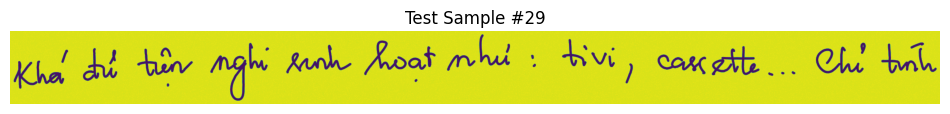

🔴 Ground Truth (Đúng):  khá đủ tiện nghi sinh hoạt như : tivi, cassette... chỉ tính
🔸 Baseline (Cũ):        kha’di tên nghị kinh hoạt mhủ: tivi, carrette... chủ tinh
✅ Fine-tune (Mới):      kha' đi tiền nghỉ kinh hoạt như : túi, cơ sở... chỉ tín
____________________________________________________________________________________________________



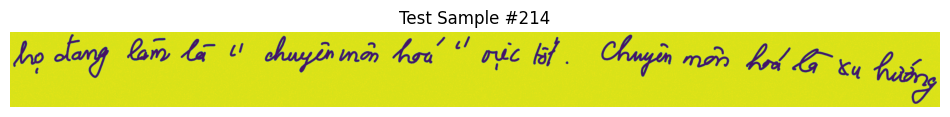

🔴 Ground Truth (Đúng):  họ đang làm là " chuyên môn hóa " việc tốt. chuyên môn hóa là xu hướng
🔸 Baseline (Cũ):        ho dong lam lai " chuyen man hoa" "riciet". chuyen man ho lai xu hong
✅ Fine-tune (Mới):      họ đăng lên là " chuyên môn hóa " " rực lét ". chuyên môn hóa là xu hướng
____________________________________________________________________________________________________



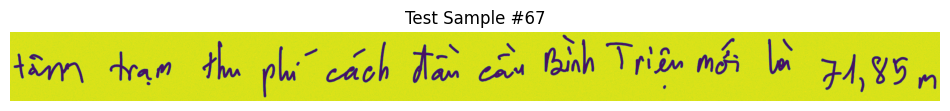

🔴 Ground Truth (Đúng):  tâm trạm thu phí cách đầu cầu bình triệu mới là 71,85 m.
🔸 Baseline (Cũ):        tam trao thu phu-ach tuan can binh trien moi lai 71,85 m
✅ Fine-tune (Mới):      tầm trạm thu phí cách đảo cầu bình triệu một là 71,85 m
____________________________________________________________________________________________________



In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# PHẦN 1: IN BẢNG SO SÁNH SỐ LIỆU
print("\n" + "="*45)
print(" 📊 BẢNG TỔNG HỢP KẾT QUẢ")
print("="*45)
print(f"{'Model':<12} | {'CER (%)':<10} | {'WER (%)':<10}")
print("-" * 45)
print(f"{'Baseline':<12} | {baseline_cer*100:.2f}%     | {baseline_wer*100:.2f}%")
print(f"{'Fine-tuned':<12} | {final_cer*100:.2f}%     | {final_wer*100:.2f}%")
print("-" * 45)
print(f"CẢI THIỆN: Giảm được {(baseline_cer - final_cer)*100:.2f}% lỗi mức ký tự (CER)")
print("="*45 + "\n")
print(f"CẢI THIỆN: Giảm được {(baseline_wer - final_wer)*100:.2f}% lỗi mức từ (WER)")
print("="*45 + "\n")

# PHẦN 2: XEM ẢNH VÀ TEXT THỰC TẾ (3 MẪU NGẪU NHIÊN)
indices = random.sample(range(len(test_set)), 3)

for i in indices:
    sample = test_set[i]

    plt.figure(figsize=(12, 3))
    try:
        img = Image.open(sample['image_path'])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Test Sample #{i}")
        plt.show()
    except:
        print("[Lỗi không load được ảnh]")

    # results: là biến chứa kết quả baseline
    # all_preds: là biến chứa kết quả fine-tune
    print(f"🔴 Ground Truth (Đúng):  {all_gts[i]}")
    print(f"🔸 Baseline (Cũ):        {results[i]}")
    print(f"✅ Fine-tune (Mới):      {all_preds[i]}")
    print("_"*100 + "\n")

### Saving, loading finetuned models

In [ ]:
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive đã được kết nối sẵn.")

save_path = "/content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned"
if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Đang lưu model vào: {save_path} ...")

model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)

print("ĐÃ LƯU THÀNH CÔNG! Kiểm tra Google Drive của bạn.")

Drive đã được kết nối sẵn.
Đang lưu model vào: /content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned ...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


ĐÃ LƯU THÀNH CÔNG! Kiểm tra Google Drive của bạn.


In [ ]:
# Khi cần dùng lại:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "/content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned", # Đường dẫn đã lưu
    load_in_4bit = True,
    # ...
)
FastVisionModel.for_inference(model)